In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv


# 📌 Loading the Data

First, I import the basic libraries for data handling and visualization. Then I load the train, test, and sample submission files provided for this Kaggle assignment. These datasets will be used for EDA, model building, and creating the final predictions.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv")
test  = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv")
sample_sub = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv")


# 📌 Handling the Arrival Date Column

The arrival column is converted into a proper datetime format so we can extract useful features from it.
Missing dates are filled using the median arrival date.

I then create three new features — arrival year, month, and day — which often help models capture booking patterns.
Finally, the original arrival column is dropped after extracting the needed information.

In [3]:
train['arrival'] = pd.to_datetime(train['arrival'], errors='coerce')
test['arrival']  = pd.to_datetime(test['arrival'], errors='coerce')

median_arr = train['arrival'].median()

train['arrival'] = train['arrival'].fillna(median_arr)
test['arrival']  = test['arrival'].fillna(median_arr)

train['arrival_year'] = train['arrival'].dt.year
train['arrival_month'] = train['arrival'].dt.month
train['arrival_day'] = train['arrival'].dt.day

test['arrival_year'] = test['arrival'].dt.year
test['arrival_month'] = test['arrival'].dt.month
test['arrival_day'] = test['arrival'].dt.day

train.drop('arrival', axis=1, inplace=True)
test.drop('arrival', axis=1, inplace=True)


# 📌 Handling Missing Values

To clean the data, I impute missing values separately for numerical and categorical features:

Numerical columns → filled with the median

Categorical columns → filled with the most frequent value

This keeps the dataset consistent and prevents errors during model training.

In [4]:
from sklearn.impute import SimpleImputer

num_cols = ['id','adults','children','weekends','weekdays','lead_time','repeat',
            'price','requests','arrival_year','arrival_month','arrival_day']
cat_cols = ['meal_type','room_type','segment']

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols]  = num_imputer.transform(test[num_cols])

train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
test[cat_cols]  = cat_imputer.transform(test[cat_cols])


# 📌 Creating Helpful New Features

To give the model more useful information, I create a few simple features:

total_days → total nights stayed (weekdays + weekends)

total_people → total guests (adults + children)

price_per_person → cost adjusted per guest

These new features help capture booking patterns more clearly and often boost model performance.

In [5]:
train['total_days'] = train['weekdays'] + train['weekends']
test['total_days']  = test['weekdays'] + test['weekends']

train['total_people'] = train['adults'] + train['children']
test['total_people']  = test['adults'] + test['children']

train['price_per_person'] = train['price'] / (train['total_people'] + 1)
test['price_per_person']  = test['price'] / (test['total_people'] + 1)


# 📌 Encoding Categorical Features

I convert the categorical columns (meal_type, room_type, segment) into numerical form using one-hot encoding.
Using drop_first=True avoids multicollinearity.

After encoding, I align the train and test datasets so they both have the same columns. Any extra column in train (the target placeholder) is removed. This ensures the model can make predictions without errors.

In [6]:
train = pd.get_dummies(train, columns=['meal_type','room_type','segment'], drop_first=True)
test  = pd.get_dummies(test,  columns=['meal_type','room_type','segment'], drop_first=True)

train, test = train.align(test, join="left", axis=1)
test['booking_status'] = 0
test = test.drop('booking_status', axis=1)


# 📌 Exploratory Data Analysis (EDA)

Here I plot a few quick visualizations to understand the data better:

Booking status distribution – helps check class balance.

Price distribution – shows how hotel prices vary across bookings.

Correlation heatmap – highlights relationships between numerical features.

These insights help guide feature engineering and model selection.

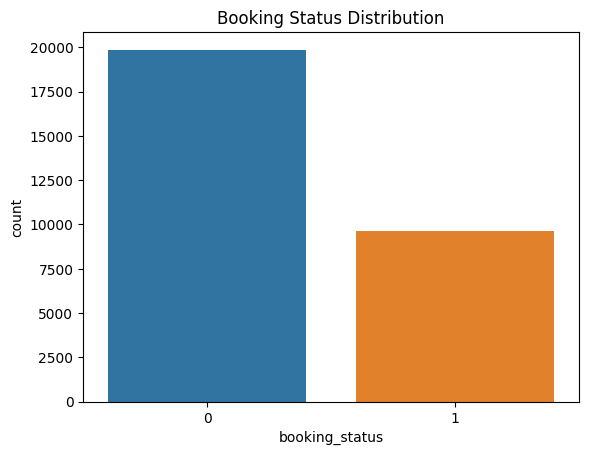

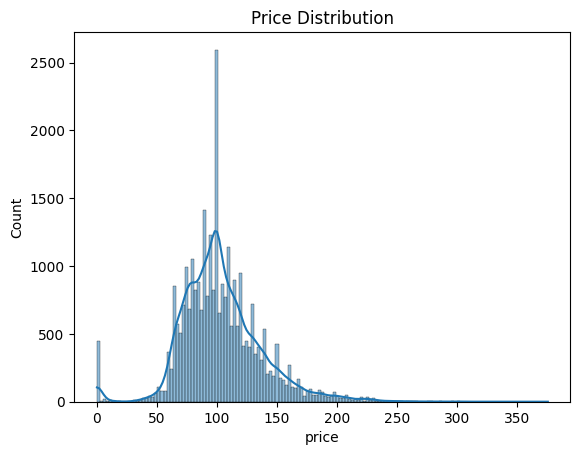

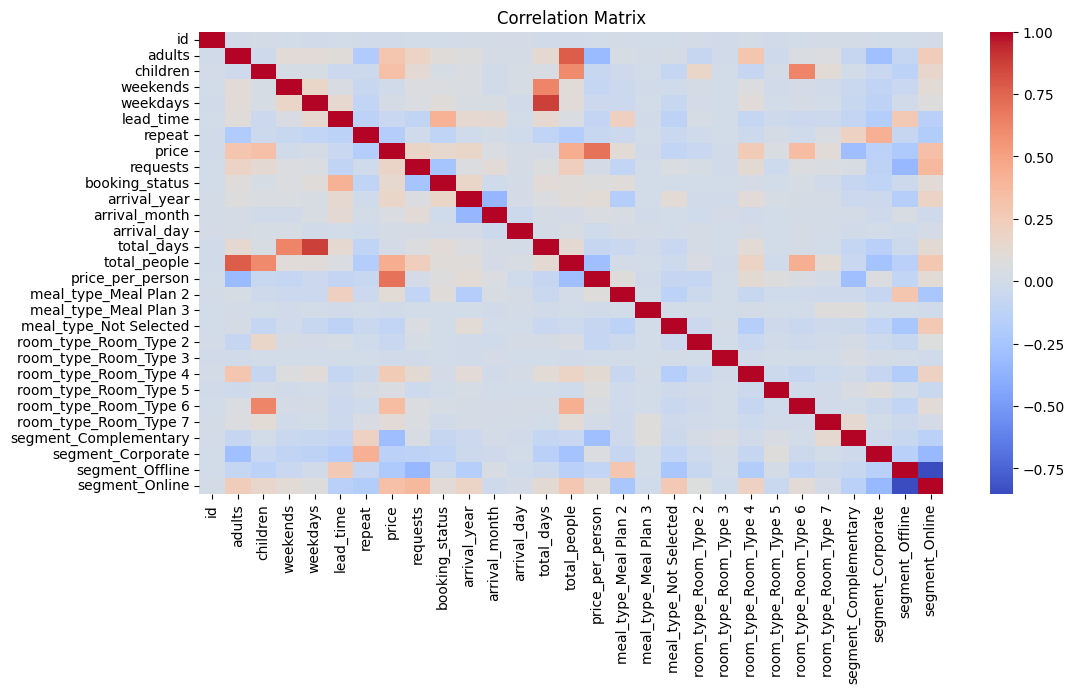

In [7]:
# 1 — Booking Status Count
sns.countplot(x=train['booking_status'])
plt.title("Booking Status Distribution")
plt.show()

# 2 — Price Distribution
sns.histplot(train['price'], kde=True)
plt.title("Price Distribution")
plt.show()

# 3 — Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# 📌 Train–Validation Split

To evaluate the model properly, I split the training data into:

80% for training, and

20% for validation

This helps check how well the model generalizes before testing on the real test dataset.

In [8]:
from sklearn.model_selection import train_test_split

X = train.drop("booking_status", axis=1)
y = train["booking_status"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# 📌 Training Multiple Models

To compare different machine learning approaches, I train several models including Logistic Regression, Random Forest, Gradient Boosting, AdaBoost, KNN, XGBoost, and LightGBM.

Each model is trained on the training split and evaluated using accuracy on the validation set.
This helps identify which models perform best before tuning and ensembling.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

models = {
    "Logistic": LogisticRegression(max_iter=500),
    "RF": RandomForestClassifier(),
    "GB": GradientBoostingClassifier(),
    "Ada": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGB": XGBClassifier(eval_metric='logloss'),
    "LGBM": LGBMClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(name, accuracy_score(y_val, preds))


Logistic 0.7830508474576271
RF 0.8835593220338983
GB 0.8383050847457627
Ada 0.8128813559322033
KNN 0.7113559322033899
XGB 0.8720338983050847
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7715, number of negative: 15885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 23600, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326907 -> initscore=-0.722209
[LightGBM] [Info] Start training from score -0.722209
LGBM 0.8683050847457627


# 📌 Hyperparameter Tuning (Random Forest)

To improve model performance, I tune the Random Forest classifier using RandomizedSearchCV.
I search over different values of tree depth, number of estimators, and split criteria.

The tuning uses 3-fold cross-validation and selects the combination that gives the highest validation accuracy.
The best model and its score are printed below.

In [10]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators':[300,400,500],
    'max_depth':[8,10,12,None],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2]
}

rf_tune = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

rf_tune.fit(X_train, y_train)
best_rf = rf_tune.best_estimator_
print("RF Best Score:", rf_tune.best_score_)


RF Best Score: 0.8825000336932548


# 📌 Hyperparameter Tuning (XGBoost)

Next, I tune the XGBoost model to find better settings for tree depth, number of estimators, and learning rate.
Using RandomizedSearchCV with 3-fold cross-validation, the search evaluates several parameter combinations and selects the one with the best accuracy score.

The best-performing XGBoost model is saved and the score is printed below.

In [11]:
xgb_params = {
    'n_estimators':[300,400],
    'max_depth':[4,6],
    'learning_rate':[0.03,0.05,0.1]
}

xgb_tune = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss'),
    xgb_params,
    n_iter=6,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

xgb_tune.fit(X_train, y_train)
best_xgb = xgb_tune.best_estimator_
print("XGB Best Score:", xgb_tune.best_score_)


XGB Best Score: 0.8766101995725551


# 📌 Hyperparameter Tuning (LightGBM)

Finally, I tune the LightGBM model using RandomizedSearchCV.
Different values of tree depth, number of estimators, and learning rate are tested using 3-fold cross-validation.

This helps LightGBM find a more optimal balance between model complexity and accuracy.
The best score from the tuning process is printed below.

In [12]:
lgb_params = {
    'n_estimators':[200,300,400],
    'max_depth':[4,6,8],
    'learning_rate':[0.03,0.05,0.1]
}

lgb_tune = RandomizedSearchCV(
    LGBMClassifier(),
    lgb_params,
    n_iter=6,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

lgb_tune.fit(X_train, y_train)
best_lgb = lgb_tune.best_estimator_
print("LGBM Best Score:", lgb_tune.best_score_)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5144, number of negative: 10590
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 15734, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326935 -> initscore=-0.722079
[LightGBM] [Info] Start training from score -0.722079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

# 📌 Selecting the Best Model & Creating Final Submission

After tuning Random Forest, XGBoost, and LightGBM, I compare their best validation scores and pick the highest-performing model.
The chosen model is then retrained on the full training data to maximize performance.

Finally, I generate predictions for the test set and save them in the required submission.csv format for Kaggle.

In [13]:
# Compare tuned scores
scores = {
    "RF": rf_tune.best_score_,
    "XGB": xgb_tune.best_score_,
    "LGB": lgb_tune.best_score_
}

print(scores)
best_model_name = max(scores, key=scores.get)
print("Best Model:", best_model_name)

best_model = {"RF":best_rf, "XGB":best_xgb, "LGB":best_lgb}[best_model_name]

# Train on full data
best_model.fit(X, y)

# Predict
test_preds = best_model.predict(test)
sample_sub['booking_status'] = test_preds
sample_sub.to_csv("submission.csv", index=False)

print("submission.csv saved!")


{'RF': 0.8825000336932548, 'XGB': 0.8766101995725551, 'LGB': 0.8733051417479811}
Best Model: RF
submission.csv saved!
